In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from experiment_mnist import *
from tfshow import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_148 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1066 - acc: 0.1239 - mean_squared_error: 0.1066 - val_loss: 0.0967 - val_acc: 0.1406 - val_mean_squared_error: 0.0967
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0943 - acc: 0.1488 - mean_squared_error: 0.0943 - val_loss: 0.0916 - val_acc: 0.1700 - val_mean_squared_error: 0.0916
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0901 - 

Epoch 39/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0488 - acc: 0.7388 - mean_squared_error: 0.0488 - val_loss: 0.0481 - val_acc: 0.7517 - val_mean_squared_error: 0.0481
Epoch 40/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0484 - acc: 0.7409 - mean_squared_error: 0.0484 - val_loss: 0.0477 - val_acc: 0.7527 - val_mean_squared_error: 0.0477
Epoch 41/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0480 - acc: 0.7455 - mean_squared_error: 0.0480 - val_loss: 0.0476 - val_acc: 0.7501 - val_mean_squared_error: 0.0476
Epoch 42/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.0477 - acc: 0.7471 - mean_squared_error: 0.0477 - val_loss: 0.0471 - val_acc: 0.7496 - val_mean_squared_error: 0.0471
Epoch 43/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0474 - acc: 0.7480 - mean_squared_error: 0.0474 - val_loss: 0.0469 - val_acc: 0.7595 - val_mean_squared_error: 0.0469


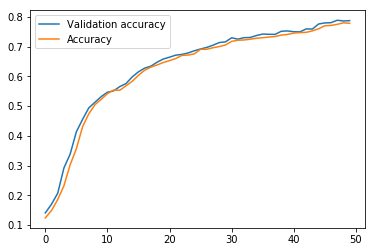

Creating network for 784-dimensional input and 10-dimensional output, with 1 hidden layers


In [27]:
experiment = MNISTExperiment([10], 0.123, 0.321, epochs = 50, activation = 'sigmoid', reg_type = 0,
                             reg_coeff = 0, do_print = True)

100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


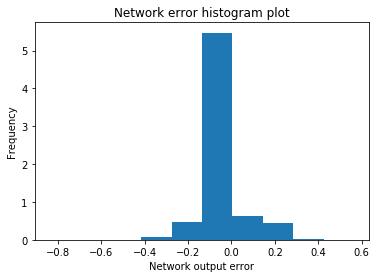

Error; maximal over inputs, average over dropout:
True values array mean: 0.099394 variance 0.197351
Experiment 0.191362 Std 0.174203
Equation   0.168127 Std 0.236135
Tightness  113.8% Std 73.8%


(0.19136189, 0.17420265, 0.16812711238861083, 0.23613473964917597, 0.19735079)

In [28]:
experiment.run(repetitions = 10000, inputs = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 10)                7850      
_________________________________________________________________
lambda_31 (Lambda)           (None, 10)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1080 - acc: 0.1196 - mean_squared_error: 0.1080 - val_loss: 0.0974 - val_acc: 0.1422 - val_mean_squared_error: 0.0974
Epoch 2/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.0946 - acc: 0.1562 - mean_squared_error: 0.0946 - val_loss: 0.0910 - val_a

60000/60000 [==============================] - 1s 12us/step - loss: 0.0634 - acc: 0.6083 - mean_squared_error: 0.0634 - val_loss: 0.0626 - val_acc: 0.6394 - val_mean_squared_error: 0.0626
Epoch 39/50
60000/60000 [==============================] - 1s 14us/step - loss: 0.0630 - acc: 0.6252 - mean_squared_error: 0.0630 - val_loss: 0.0625 - val_acc: 0.6390 - val_mean_squared_error: 0.0625
Epoch 40/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0628 - acc: 0.6309 - mean_squared_error: 0.0628 - val_loss: 0.0621 - val_acc: 0.6455 - val_mean_squared_error: 0.0621
Epoch 41/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0622 - acc: 0.6394 - mean_squared_error: 0.0622 - val_loss: 0.0615 - val_acc: 0.6507 - val_mean_squared_error: 0.0615
Epoch 42/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.0619 - acc: 0.6468 - mean_squared_error: 0.0619 - val_loss: 0.0616 - val_acc: 0.6549 - val_mean_squared_error: 0.0616
Epoch 43/50


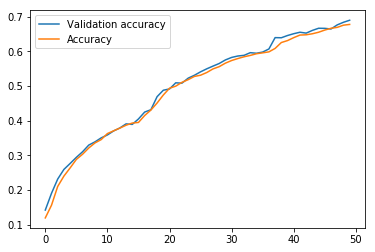

Creating network for 784-dimensional input and 10-dimensional output, with 1 hidden layers


In [29]:
experiment = MNISTExperiment([10], 0.123, 0.321, epochs = 50, activation = 'sigmoid', reg_type = 0,
                             reg_coeff = 0, do_print = True, train_dropout = [0.1, 0.1, 0.1])

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


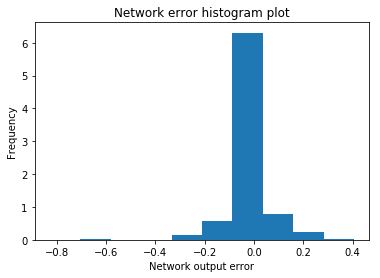

Error; maximal over inputs, average over dropout:
True values array mean: 0.102991 variance 0.177406
Experiment 0.171927 Std 0.211373
Equation   0.129014 Std 0.253259
Tightness  133.3% Std 83.5%


(0.17192715, 0.21137339, 0.12901377725601196, 0.25325932634814763, 0.17740573)

In [30]:
experiment.run(repetitions = 10000, inputs = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_160 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.1104 - acc: 0.1153 - mean_squared_error: 0.1048 - val_loss: 0.0990 - val_acc: 0.1723 - val_mean_squared_error: 0.0937
Epoch 2/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0955 - acc: 0.2081 - mean_squared_error: 0.0903 - val_loss: 0.0917 - val_acc: 0.2937 - val_mean_squared_error: 0.0866
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0903 - 

Epoch 39/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.0583 - acc: 0.7932 - mean_squared_error: 0.0504 - val_loss: 0.0579 - val_acc: 0.7936 - val_mean_squared_error: 0.0500
Epoch 40/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.0579 - acc: 0.7962 - mean_squared_error: 0.0499 - val_loss: 0.0576 - val_acc: 0.7977 - val_mean_squared_error: 0.0496
Epoch 41/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0576 - acc: 0.7977 - mean_squared_error: 0.0495 - val_loss: 0.0572 - val_acc: 0.8007 - val_mean_squared_error: 0.0492
Epoch 42/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0572 - acc: 0.8001 - mean_squared_error: 0.0491 - val_loss: 0.0569 - val_acc: 0.8030 - val_mean_squared_error: 0.0487
Epoch 43/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.0569 - acc: 0.8023 - mean_squared_error: 0.0487 - val_loss: 0.0566 - val_acc: 0.8025 - val_mean_squared_error: 0.0484


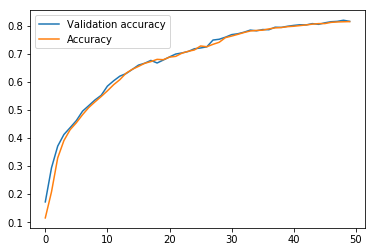

Creating network for 784-dimensional input and 10-dimensional output, with 1 hidden layers


In [31]:
experiment = MNISTExperiment([10], 0.123, 0.321, epochs = 50, activation = 'sigmoid', reg_type = 'delta',
                             reg_coeff = 0.01, do_print = True)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


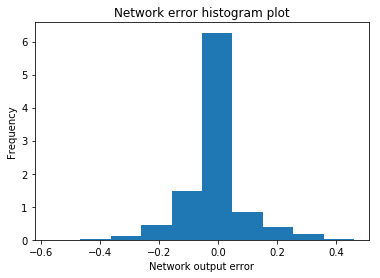

Error; maximal over inputs, average over dropout:
True values array mean: 0.100914 variance 0.168257
Experiment 0.165588 Std 0.150335
Equation   0.116372 Std 0.181519
Tightness  142.3% Std 82.8%


(0.16558793, 0.15033463, 0.11637189781665802, 0.18151916167491614, 0.16825712)

In [33]:
experiment.run(repetitions = 10000, inputs = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_166 (Dense)            (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2892 - acc: 0.1371 - mean_squared_error: 0.1008 - val_loss: 0.2651 - val_acc: 0.1576 - val_mean_squared_error: 0.0932
Epoch 2/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2518 - acc: 0.1985 - mean_squared_error: 0.0908 - val_loss: 0.2342 - val_acc: 0.2506 - val_mean_squared_error: 0.0876
Epoch 3/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.2237 - 

Epoch 39/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0653 - acc: 0.7534 - mean_squared_error: 0.0538 - val_loss: 0.0645 - val_acc: 0.7771 - val_mean_squared_error: 0.0529
Epoch 40/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0653 - acc: 0.7561 - mean_squared_error: 0.0537 - val_loss: 0.0622 - val_acc: 0.8259 - val_mean_squared_error: 0.0506
Epoch 41/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0634 - acc: 0.7800 - mean_squared_error: 0.0518 - val_loss: 0.0628 - val_acc: 0.8064 - val_mean_squared_error: 0.0513
Epoch 42/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0646 - acc: 0.7657 - mean_squared_error: 0.0530 - val_loss: 0.0653 - val_acc: 0.7713 - val_mean_squared_error: 0.0536
Epoch 43/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.0632 - acc: 0.7858 - mean_squared_error: 0.0516 - val_loss: 0.0612 - val_acc: 0.8262 - val_mean_squared_error: 0.0496


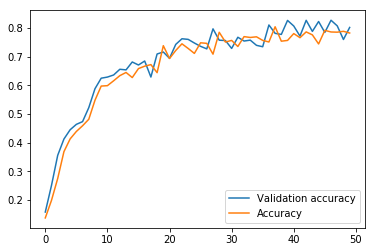

Creating network for 784-dimensional input and 10-dimensional output, with 1 hidden layers


In [34]:
experiment = MNISTExperiment([10], 0.123, 0.321, epochs = 50, activation = 'sigmoid', reg_type = 'l2',
                             reg_coeff = 0.01, do_print = True)

100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


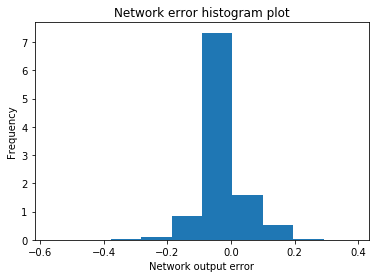

Error; maximal over inputs, average over dropout:
True values array mean: 0.098383 variance 0.146461
Experiment 0.117776 Std 0.117362
Equation   0.115002 Std 0.169245
Tightness  102.4% Std 69.3%


(0.11777565, 0.11736231, 0.11500241965055466, 0.169245007462801, 0.14646089)

In [35]:
experiment.run(repetitions = 10000, inputs = 50)

1. Regularization with dropout, l2 and delta result in decrease of error
2. Tightness is best for delta